In [1]:
# !pip install visdom

## Imports

### Standard Imports

In [2]:
from __future__ import print_function
from __future__ import division

from pprint import pprint
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import scipy.stats as sts

import argparse
import copy
import datetime
import os
import random
import skimage
import shutil
import time
# import visdom
import warnings

### Torch imports

In [3]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

### Sklearn Imports

In [4]:
from sklearn.model_selection import ParameterGrid

## Setting Notebook

### Custom Argparser

In [5]:
parser = argparse.ArgumentParser(description='PyTorch SirenNet Training')
"""parser.add_argument('data', metavar='DIR',
                    help='path to dataset')"""
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate, (default: 1e-4)', dest='lr')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')
parser.add_argument('--results-path', default="results", type=str, dest="results_path",
                    help='Local File System path where results will be stored')
parser.add_argument('--image_path', type=str, dest="image_path",
                    help='Local File System path related to input image to be processed')
parser.add_argument('--num-trials-per-img', type=int, default=5, dest="num_trials",
                    help='Number of trials per image (default: 5)')
parser.add_argument('--compression-factor', type=int, default=128, dest="compression_factor",
                    help='Image\'s compression factor (default: 128)')

_StoreAction(option_strings=['--compression-factor'], dest='compression_factor', nargs=None, const=None, default=128, type=<class 'int'>, choices=None, help="Image's compression factor (default: 128)", metavar=None)

In [6]:
args, unknown = parser.parse_known_args()

pprint(args)

Namespace(batch_size=256, compression_factor=128, epochs=90, evaluate=False, gpu=None, image_path=None, lr=0.0001, momentum=0.9, num_trials=5, print_freq=10, results_path='results', seed=None, start_epoch=0, weight_decay=0.0001)


In [7]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


### Set seeds for repeatability

In [8]:
if args.seed == None: args.seed = 0

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_extract = True

### Set device - either gpu:0 or cpu

In [9]:
# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (torch.device('cuda:0') if torch.cuda.is_available()
    else torch.device('gpu'))
print(f"Training on device {device}.")
print(f"# cuda device: {torch.cuda.device_count()}")
print(f"Id current device: {torch.cuda.current_device()}")

Training on device cuda:0.
# cuda device: 1
Id current device: 0


## Siren Hyper-parameters

In [10]:
# Siren's architecture Hyper-params
in_features = 2
out_features = 1
sidelength = args.compression_factor # 256
hidden_layers = 3

# Training phase's Hyper-params
learning_rate = args.lr
epochs = args.epochs

# Displaying Images
num_trials = args.num_trials
steps_til_summary = args.print_freq

if args.image_path is None:
    # image_path = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68/test001.png"
    image_path = "/content/test001.png"
else: image_path = args.image_path

In [44]:
root_analisys = "/content/drive/My Drive/Siren Deep Learning Analyses/"

results_path = "results"
dataset_name = "BSD68"
image_name = "test001"

results_dataset_dir = os.path.join(root_analisys, results_path, dataset_name)
results_img_dir = os.path.join(root_analisys, results_path, dataset_name, image_name)

try: os.makedirs(results_dataset_dir)
except: pass

try: os.makedirs(results_img_dir)
except: pass

df_results_path = os.path.join(results_dataset_dir, "results.csv")
"""
df_results_path = os.path.join(results_dataset_dir, "results.csv")
if os.path.exists(df_results_path) and os.path.isfile(df_results_path):
    df_results = pd.read_csv(df_results_path)
else:
    columns_df = "timestamp;dataset;image;seed;last_train_loss;arch;args;".split(";")
    df_results = pd.DataFrame(columns = columns_df)
df_results.head(5)
"""

'\ndf_results_path = os.path.join(results_dataset_dir, "results.csv")\nif os.path.exists(df_results_path) and os.path.isfile(df_results_path):\n    df_results = pd.read_csv(df_results_path)\nelse:\n    columns_df = "timestamp;dataset;image;seed;last_train_loss;arch;args;".split(";")\n    df_results = pd.DataFrame(columns = columns_df)\ndf_results.head(5)\n'

In [12]:
# from sklearn.model_selection import ParameterGrid
# import numpy as np
grid = {
    "compression":  (16, 32, 64, 128, 256), # np.power(np.ones(9, dtype = np.int32) * 2, np.arange(0, 9))[4:6],
    "hidden_layers": (2, 3, 5, 7, 9, 11, 13, 15, 17)[:],
    "seed": (0, 17, 42, 101, 123, 1234)[:],
    "num_trials": (10,), # "num_trials": (num_trials,),
}
params_grid = ParameterGrid(grid)

## Functions

### Utils

In [ ]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [13]:
def show_advanced_boxplot(values_list, names_list, fig_name = "boxplot.png"):
    N = len(values_list[0])
    data = values_list
    randomDists= names_list
    numDists = len(names_list)

    fig, ax1 = plt.subplots(figsize=(20, 20))
    fig.canvas.set_window_title('Boxplot Per Group')
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    # Hide these grid behind plot objects
    ax1.set_axisbelow(True)
    ax1.set_title('Comparison of Training Loss per Group')
    ax1.set_xlabel('Group')
    ax1.set_ylabel('Value')

    # Now fill the boxes with desired colors
    boxColors = ['darkkhaki', 'royalblue']
    numBoxes = numDists 
    medians = list(range(numBoxes))
    for i in range(numBoxes):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        # Alternate between Dark Khaki and Royal Blue
        k = i % 2
        boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
        ax1.add_patch(boxPolygon)
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
            plt.plot(medianX, medianY, 'k')
            medians[i] = medianY[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, numBoxes + 0.5)
    top = 0.03
    bottom = 0
    ax1.set_ylim(bottom, top)
    xtickNames = plt.setp(ax1, xticklabels=np.repeat(randomDists, 1))
    plt.setp(xtickNames, rotation=45, fontsize=8)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(numBoxes) + 1
    # upperLabels = [str(np.round(s, 5)) for s in medians]
    upperLabels = ['%.3E' %  np.round(s, 5) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])

    # Finally, add a basic legend
    """
    plt.figtext(0.80, 0.08, str(N) + ' Trial Numbers',
            backgroundcolor=boxColors[0], color='black', weight='roman',
            size='x-small')
    plt.figtext(0.80, 0.045, 'IID Bootstrap Resample',
            backgroundcolor=boxColors[1],
            color='white', weight='roman', size='x-small')
    plt.figtext(0.80, 0.015, '*', color='white', backgroundcolor='silver',
            weight='roman', size='medium')
    """
    plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman',
            size='x-small')

    plt.legend()
    plt.savefig(fig_name)
    plt.show()
    pass

In [14]:
def get_all_images_from_path(path_images):
    # bsd68_path = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68"
    images = []
    
    for (dirpath, dirnames, filenames) in os.walk(path_images):
        full_file_path_list = list()
        for a_file in sorted(filenames):
            full_file_path_list.append(os.path.join(dirpath, a_file))
            pass
        images.extend(full_file_path_list)
        pass
    return images

In [15]:
def show_hist_kde_train_loss(samples, bins = 10, fig_name="hist_kde_train_loss.png", resample_from_hist = False):
    n = len(samples)
    
    h, e = np.histogram(samples, bins=bins, density=True)
    x = np.linspace(e.min(), e.max())

    # plot the histogram
    plt.figure(figsize=(8,6))
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

    # plot the real KDE
    try:
        kde = sts.gaussian_kde(samples)
        plt.plot(x, kde.pdf(x), c='C1', lw=8, label='KDE')
    except:
        pass

    if resample_from_hist is True:
        # resample the histogram and find the KDE.
        try:
            resamples = np.random.choice((e[:-1] + e[1:])/2, size=n*5, p=h/h.sum())
            rkde = sts.gaussian_kde(resamples)

            # plot the KDE
            plt.plot(x, rkde.pdf(x), '--', c='C3', lw=4, label='resampled KDE')
        except:
            pass
        pass
    
    plt.title('Train Loss: n = %d samples' % n)
    plt.legend()
    plt.savefig(fig_name)
    plt.show()
    pass

In [16]:
def printImageAttributes(imageObject, imagePath):

    # Retrieve the attributes of the image

    fileFormat      = imageObject.format        # Format of the image
    imageMode       = imageObject.mode          # Mode of the image
    imageSize       = imageObject.size          # Size of the image - tupe of (width, height)
    colorPalette    = imageObject.palette       # Palette used in the image

    # Print the attributes of the image
    print("Attributes of image:%s"%imagePath)
    print("The file format of the image is:%s"%fileFormat)
    print("The mode of the image is:%s"%imageMode)
    print("The size of the image is:width %d pixels,height %d pixels"%imageSize)
    print("Color palette used in image:%s"%colorPalette)
    print("Keys from image.info dictionary:%s")

    for key, value in imageObject.info.items() :
        print(key); print(value)
        pass
    pass

def get_cameraman_tensor(sidelength):
    # print(type(skimage.data.camera()))
    img = Image.fromarray(skimage.data.camera())
    
    # print(type(img))
    printImageAttributes(img, "cameraman")

    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [17]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [18]:
def get_model(in_features, out_features, hidden_features, hidden_layers):
    img_siren = Siren(
        in_features = in_features,
        out_features = out_features,
        hidden_features = hidden_features, 
        hidden_layers = hidden_layers,
        outermost_linear=True)
    img_siren.cuda()
    return img_siren

In [19]:
def get_information_model(model):
    model = model.to(device)

    numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
    print(model)
    print(sum(numel_list), numel_list)

    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    pass

### Trainining Loop: Show Image Estimate Progression

In [20]:
def show_images(model_output, coords):
    img_grad = gradient(model_output, coords)
    img_laplacian = laplace(model_output, coords)

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(model_output.cpu().view(sidelength, sidelength).detach().numpy())
    axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength, sidelength).detach().numpy())
    axes[2].imshow(img_laplacian.cpu().view(sidelength, sidelength).detach().numpy())
    plt.show()
    pass

def basic_traininig_loop(optimizer, criterion, model, model_input, ground_truth, total_steps, steps_til_summary = 10):
    
    train_acc_history = [] # val_acc_history = []
    train_loss_history = [] # val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()  # Set model to training mode

    for step in range(total_steps):
        # print('Epoch {}/{}'.format(step, total_steps - 1))
        # print('-' * 10)

        model_output, coords = model(model_input)
        loss = criterion(model_output, ground_truth)  
        # loss = ((model_output - ground_truth)**2).mean()
    
        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
            show_images(model_output, coords)
            pass
        
        train_loss_history.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        best_model_wts = copy.deepcopy(model.state_dict())
        pass
    

    # load best model weights
    model.load_state_dict(best_model_wts)

    # create history as python dictionary
    keys_history_list = "train_loss".split(",")
    values_history_list = [train_loss_history]

    history = dict(zip(keys_history_list, values_history_list))

    return model, history

### Plane Training Loop

In [21]:
def plane_traininig_loop(optimizer, criterion, model, model_input, ground_truth, total_steps, verbose = 0):
    
    train_acc_history = [] # val_acc_history = []
    train_loss_history = [] # val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    model.train()  # Set model to training mode

    phase = 'train'
    for step in range(total_steps):
        if verbose == 1:
            print('Epoch {}/{}'.format(step, total_steps - 1))
            print('-' * 10)

        model_output, coords = model(model_input)    
        loss = criterion(model_output, ground_truth)
        # loss = ((model_output - ground_truth)**2).mean()
        
        if verbose == 1:
            print('{} Loss: {:.4f}'.format(phase, loss))
        train_loss_history.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        best_model_wts = copy.deepcopy(model.state_dict())
        pass
    

    # load best model weights
    model.load_state_dict(best_model_wts)

    # create history as python dictionary
    keys_history_list = "train_loss".split(",")
    values_history_list = [train_loss_history]

    history = dict(zip(keys_history_list, values_history_list))

    return model, history

### Training Loop: Run through a whole set of images

In [22]:
def a_training_loop(images, first_image_pos, last_image_pos, sidelength = 128, lr = 1e-4, total_steps = 500, verbose = 0):
    records_list = []
    for _, image_path in enumerate(images[first_image_pos:last_image_pos]):

        # Create a DataLoader Instance for current image to be fitted
        # -------------------------------------------------------------------- #
        image = ImageFitting(
            sidelength,
            image_path = image_path)
        dataloader = DataLoader(image,
            batch_size=1,
            pin_memory=True,
            num_workers=0)

        img_siren = get_model(
            in_features = in_features,
            out_features = out_features,
            hidden_features = sidelength,
            hidden_layers = hidden_layers)

        # Establish Number of steps, criterion, and loss function
        # -------------------------------------------------------------------- #
        # total_steps = 500 
        # Since the whole image is our dataset, this just means 500 gradient descent steps.

        criterion = nn.MSELoss()
        optim = torch.optim.Adam(lr=lr, params=img_siren.parameters())

        model_input, ground_truth = next(iter(dataloader))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

        # Proceed with training
        # -------------------------------------------------------------------- #
        start = time.time()
        # model, history = basic_traininig_loop(
        model, history = plane_traininig_loop(
            optimizer = optim,
            criterion = criterion,
            model = img_siren,
            model_input = model_input,
            ground_truth = ground_truth,
            # total_steps = total_steps, steps_til_summary = steps_til_summary)
            total_steps = total_steps)
        stop = time.time()

        # times = (stop - start) * 1000
        times = (stop - start)
        if verbose == 1:
            print('-' * 40)
            # print('Run time takes %d miliseconds' % times) # print('Run time takes %.3f seconds' % times)
            print('Training complete in {:.0f}m {:.0f}s {:.0f}ms'
                .format(times // 60, times % 60, (times - int((times % 60))) * 1000))

        # Save results for current trained image
        # -------------------------------------------------------------------- #
        image_name = os.path.basename(image_path)
        last_loss_train = history['train_loss'][-1]
        a_record = [image_name, last_loss_train.item(), times]

        records_list.append(a_record)
        pass
    return model, history, records_list

In [23]:
def run_over_images(num_trials, images, first_image_pos, last_image_pos, sidelength = 128, lr = 1e-4, total_steps = 500, verbose = 0):
    df, tmp_df = None, None
    for ii, a_trial in enumerate(range(num_trials)):
        start = time.time()

        model, history, records = a_training_loop(images, first_image_pos, last_image_pos, sidelength = sidelength, lr = 1e-4, total_steps = 500)

        stop = time.time()
        times = (stop - start)
        if verbose == 1:
            print('-' * 40)
            print('[Trial no.{:.0f}] [Outer Loop] Training complete in {:.0f}m {:.0f}s {:.0f}ms'
                .format(a_trial, times // 60, times % 60, (times - int((times % 60))) * 1000))
    
    
        if df is None:
            columns = "image,train_loss,time".split(",")
            df = pd.DataFrame(data = records,  columns = columns, index = [f"trial no.{ii}"] * len(records))
            df_show_curr_stats = df
        else:
            columns = "image,train_loss,time".split(",")
            tmp_df = pd.DataFrame(data = records,  columns = columns, index = [f"trial no.{ii}"] * len(records))
            df_show_curr_stats = tmp_df
            df = pd.concat([df, tmp_df])
    
        print(df_show_curr_stats[['train_loss']].describe().T)
        pass
    return df

### Training Loop: Grid Search

In [24]:
def run_over_trials(num_trials, optim, criterion, model, model_input, ground_truth, total_steps = 500,  verbose = 0):
    records_list = []
    for ii, a_trial in enumerate(range(num_trials)):
        start = time.time()

        # model, history = basic_traininig_loop(
        model, history = plane_traininig_loop(
            optimizer = optim,
            criterion = criterion,
            model = model,
            model_input = model_input,
            ground_truth = ground_truth,
            # total_steps = total_steps, steps_til_summary = steps_til_summary)
            total_steps = total_steps)

        stop = time.time()
        times = (stop - start)
        if verbose == 1:
            print('-' * 40)
            print('[Trial no.{:.0f}] [Outer Loop] Training complete in {:.0f}m {:.0f}s {:.0f}ms'
                .format(a_trial, times // 60, times % 60, (times - int((times % 60))) * 1000))

        last_loss_train = history['train_loss'][-1]
        a_record = [last_loss_train.item(), times]

        records_list.append(a_record)
        pass
    
    return records_list 

def grid_search_training_loop(params_grid, image_path, in_features, out_features, lr = 1e-4, total_steps = 500, verbose = 0):
    records_list, indeces = [], []

    n = len(list(params_grid))
    for ii, params_dict in enumerate(list(params_grid)):

        if ii != 0: print()

        print(f"[*] Grid Search no. {ii + 1} / {n}")
        print("=" * 40)

        torch.manual_seed(params_dict['seed'])
        np.random.seed(params_dict['seed'])
        random.seed(params_dict['seed'])

        # Create a DataLoader Instance for current image to be fitted
        # -------------------------------------------------------------------- #
        image = ImageFitting(
            params_dict['compression'],
            image_path = image_path)
        dataloader = DataLoader(image,
            batch_size=1,
            pin_memory=True,
            num_workers=0)

        img_siren = get_model(
            in_features = in_features,
            out_features = out_features,
            hidden_features = params_dict['compression'],
            hidden_layers = params_dict['hidden_layers'])

        # Establish Number of steps, criterion, and loss function
        # -------------------------------------------------------------------- #
        # total_steps = 500 
        # Since the whole image is our dataset, this just means 500 gradient descent steps.

        criterion = nn.MSELoss()
        optim = torch.optim.Adam(lr=lr, params=img_siren.parameters())

        model_input, ground_truth = next(iter(dataloader))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

        # Proceed with training
        # -------------------------------------------------------------------- #
        start = time.time()
        history_trials = run_over_trials(
            params_dict['num_trials'], optim, criterion,
            img_siren,
            model_input, ground_truth,
            total_steps = total_steps)
        stop = time.time()

        # times = (stop - start) * 1000
        times = (stop - start)
        if verbose == 1:
            # print('Run time takes %d miliseconds' % times) # print('Run time takes %.3f seconds' % times)
            print('[+][Grid Search no. {}] Training complete in {:.0f}m {:.0f}s {:.0f}ms'
                .format(ii+1, times // 60, times % 60, (times - int((times % 60))) * 1000))

        # Save results for current trained image
        # -------------------------------------------------------------------- #
        image_name = os.path.basename(image_path)
        a_record = [image_name, int(params_dict['compression']), int(params_dict['hidden_layers']), int(params_dict['seed'])] 

        trial_ith_records = list(map(lambda a_item: a_record + a_item, history_trials))
        records_list.extend(trial_ith_records)
        indeces.extend(list(map(lambda x: f"trial no.{x}", np.arange(params_dict['num_trials']))))

        columns = "image;compression_factor;hidden_layers;seed;last_train_loss;time".split(";")
        print(pd.DataFrame(data = trial_ith_records, columns = columns)[["last_train_loss"]].describe().T)
        pass

    stop_grid_search = time.time()
    columns = "image;compression_factor;hidden_layers;seed;last_train_loss;time".split(";")
    df = pd.DataFrame(data = records_list, columns = columns, index = indeces)
    return df

## Siren Classes

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [25]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, image_path = None):
        super().__init__()
        if image_path is None:
            img = get_cameraman_tensor(sidelength)
        else:
            imag = Image.open(image_path)
            imag = imag.resize((sidelength, sidelength))
            # printImageAttributes(imag, image_path)
            # imag = np.asarray(imag)
            transform = Compose([
                Resize(sidelength),
                ToTensor(),
                Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
            img = transform(imag)
            pass
        
        # print(type(img))
        # print(img.size())

        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        pass

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
    pass

In [26]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [27]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Experiments

### Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that: $\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$ is minimized, in which $\Omega$ is the domain of the image.

We write a little datast that does nothing except calculating per-pixel coordinates:

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [28]:
start = time.time()
df = grid_search_training_loop(
    params_grid, image_path,
    in_features, out_features,
    lr = learning_rate,
    total_steps = epochs, verbose = 1)

stop = time.time()
times = (stop - start)

[*] Grid Search no. 1 / 270
[Grid Search no. 1] Training complete in 0m 4s 610ms
                 count      mean       std  ...       50%       75%     max
last_train_loss   10.0  0.015103  0.026847  ...  0.003973  0.010772  0.0876

[1 rows x 8 columns]
[*] Grid Search no. 2 / 270
[Grid Search no. 2] Training complete in 0m 4s 823ms
                 count      mean       std  ...       50%       75%       max
last_train_loss   10.0  0.018123  0.033731  ...  0.002722  0.013051  0.106605

[1 rows x 8 columns]
[*] Grid Search no. 3 / 270
[Grid Search no. 3] Training complete in 0m 4s 990ms
                 count      mean       std  ...       50%       75%      max
last_train_loss   10.0  0.028469  0.048232  ...  0.004395  0.026847  0.14571

[1 rows x 8 columns]
[*] Grid Search no. 4 / 270
[Grid Search no. 4] Training complete in 0m 4s 817ms
                 count      mean       std  ...       50%       75%       max
last_train_loss   10.0  0.021256  0.039614  ...  0.003074  0.014276  0

In [29]:
print('-' * 40)
# print('Run time takes %d miliseconds' % times) # print('Run time takes %.3f seconds' % times)
print('[Grid Search] complete in {:.0f}m {:.0f}s {:.0f}ms'
    .format(times // 60, times % 60, (times - int((times % 60))) * 1000))

----------------------------------------
[Grid Search] complete in 83m 12s 4980791ms


In [30]:
df.head(5)

,image,compression_factor,hidden_layers,seed,last_train_loss,time
trial no.0,test001.png,16,2,0,0.087600,0.360738
trial no.1,test001.png,16,2,0,0.029229,0.370306
trial no.2,test001.png,16,2,0,0.012074,0.357997
trial no.3,test001.png,16,2,0,0.006865,0.350502
trial no.4,test001.png,16,2,0,0.004592,0.360299


In [31]:
df.describe()

,compression_factor,hidden_layers,seed,last_train_loss,time
count,2700.000000,2700.000000,2700.000000,2.700000e+03,2700.000000
mean,99.200000,9.111111,252.833333,7.825920e-03,1.816125
std,87.300531,4.999691,441.025899,2.084599e-02,2.190242
min,16.000000,2.000000,0.000000,7.720014e-07,0.339546
25%,32.000000,5.000000,17.000000,2.842446e-04,0.637121
50%,64.000000,9.000000,71.500000,1.426676e-03,1.091119
75%,128.000000,13.000000,123.000000,5.806762e-03,1.517909
max,256.000000,17.000000,1234.000000,1.989814e-01,9.816886


In [32]:
tmp_df = df.copy()

In [33]:
# Show Average Last Train Loss per group, aggregated as follows:
df.groupby(by = ["compression_factor", "hidden_layers", "seed"]).mean()[["last_train_loss"]]

last_train_loss
compression_factor hidden_layers seed                 
16                 2             0            0.015103
                                 17           0.018123
                                 42           0.028469
                                 101          0.021256
                                 123          0.043297
...                                                ...
256                17            17           0.004718
                                 42           0.016888
                                 101          0.016970
                                 123          0.003272
                                 1234         0.007223

[270 rows x 1 columns]

In [34]:
# Describe some statistics Last Train Loss per group, aggregated as follows:
df.groupby(by = ["compression_factor", "hidden_layers", "seed"]).mean()[["last_train_loss"]].describe()

,last_train_loss
count,270.000000
mean,0.007826
std,0.009828
min,0.000911
25%,0.001806
50%,0.004246
75%,0.009222
max,0.050692


In [35]:
# Get all Last Train Losses to be print by means hist, kde, boxplots and others:
samples = np.array(df.groupby(by = ["compression_factor", "hidden_layers", "seed"]).mean()[["last_train_loss"]].values).flat
# np.isnan(samples); np.isinf(samples)

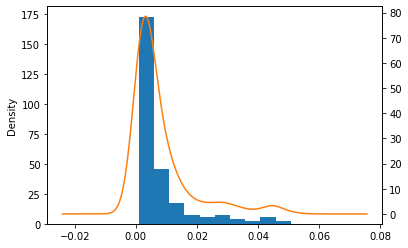

In [36]:
# show_hist_kde_train_loss(samples, bins = 10)
s = pd.Series(samples)
ax = s.plot(kind='hist')
s.plot(kind='kde', ax=ax, secondary_y=True) # ax = s.plot.kde()

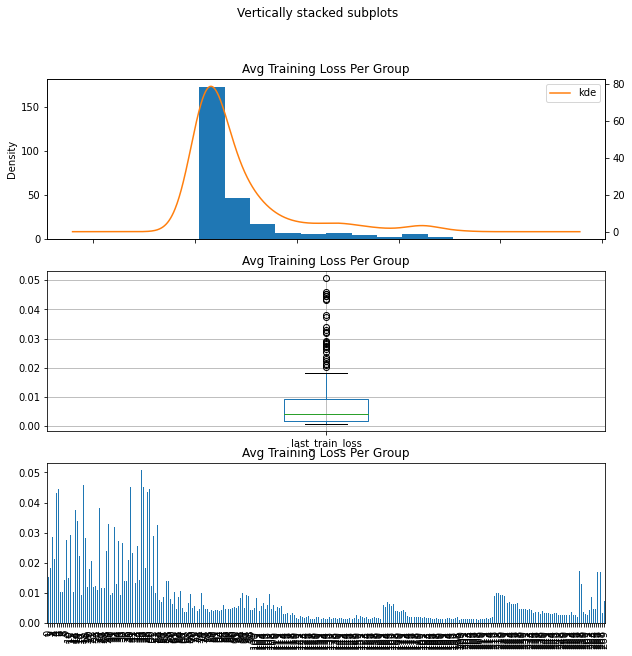

In [37]:
fig, axs = plt.subplots(3, figsize=(10, 10))
fig.suptitle('Vertically stacked subplots')

s.plot(kind='hist', ax = axs[0], label='histogram')
s.plot(kind='kde', ax=axs[0], secondary_y=True, label='kde') # ax = s.plot.kde()
axs[0].set_title('Avg Training Loss Per Group')
plt.legend()

df.groupby(by = ["compression_factor", "hidden_layers", "seed"]).mean()[["last_train_loss"]].boxplot(ax = axs[1])
axs[1].set_title('Avg Training Loss Per Group')

s.plot(kind='bar', ax = axs[2], label='line')
axs[2].set_title('Avg Training Loss Per Group')

plt.legend()

In [38]:
# df.groupby(by = ["compression_factor", "hidden_layers", "seed"]).head(5) # .boxplot(column = ['last_train_loss'], subplots=False)
grouped = df.groupby(by = ["compression_factor", "hidden_layers", "seed"])

In [39]:
values_list = []
names_list = []
for name, group in grouped:
    values_list.append(group['last_train_loss'].values)
    names_list.append(str(name))
    pass

In [40]:
names_list

['(16, 2, 0)',
 '(16, 2, 17)',
 '(16, 2, 42)',
 '(16, 2, 101)',
 '(16, 2, 123)',
 '(16, 2, 1234)',
 '(16, 3, 0)',
 '(16, 3, 17)',
 '(16, 3, 42)',
 '(16, 3, 101)',
 '(16, 3, 123)',
 '(16, 3, 1234)',
 '(16, 5, 0)',
 '(16, 5, 17)',
 '(16, 5, 42)',
 '(16, 5, 101)',
 '(16, 5, 123)',
 '(16, 5, 1234)',
 '(16, 7, 0)',
 '(16, 7, 17)',
 '(16, 7, 42)',
 '(16, 7, 101)',
 '(16, 7, 123)',
 '(16, 7, 1234)',
 '(16, 9, 0)',
 '(16, 9, 17)',
 '(16, 9, 42)',
 '(16, 9, 101)',
 '(16, 9, 123)',
 '(16, 9, 1234)',
 '(16, 11, 0)',
 '(16, 11, 17)',
 '(16, 11, 42)',
 '(16, 11, 101)',
 '(16, 11, 123)',
 '(16, 11, 1234)',
 '(16, 13, 0)',
 '(16, 13, 17)',
 '(16, 13, 42)',
 '(16, 13, 101)',
 '(16, 13, 123)',
 '(16, 13, 1234)',
 '(16, 15, 0)',
 '(16, 15, 17)',
 '(16, 15, 42)',
 '(16, 15, 101)',
 '(16, 15, 123)',
 '(16, 15, 1234)',
 '(16, 17, 0)',
 '(16, 17, 17)',
 '(16, 17, 42)',
 '(16, 17, 101)',
 '(16, 17, 123)',
 '(16, 17, 1234)',
 '(32, 2, 0)',
 '(32, 2, 17)',
 '(32, 2, 42)',
 '(32, 2, 101)',
 '(32, 2, 123)',
 '(3

No handles with labels found to put in legend.


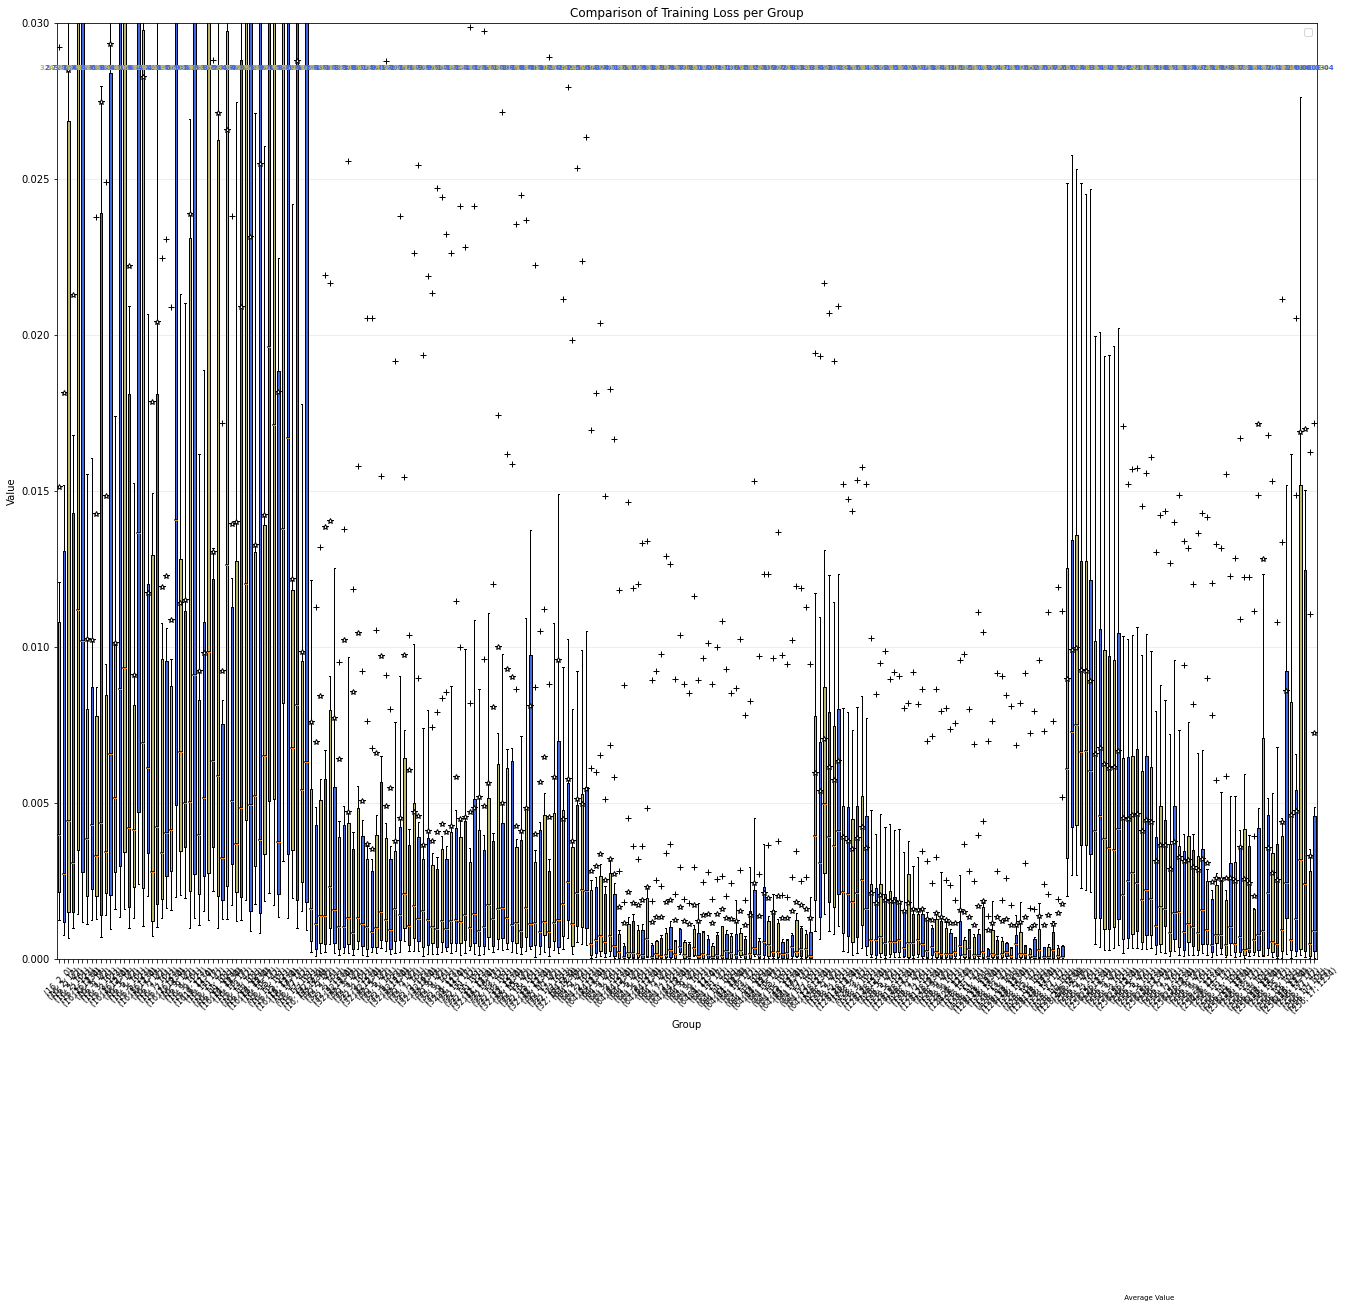

In [41]:
# show_advanced_boxplot(values_list, names_list)
show_advanced_boxplot(values_list, names_list)

In [42]:
# hist = df.hist(column = ['train_loss'], bins = 10)
# ax = df[['train_loss']].plot.kde()
# show_hist_kde_train_loss(bins = 10)

In [45]:
tmp_df.to_csv(df_results_path)

## References

### Compression Algorithms:

- [zlib](http://www.zlib.net/)

### Tutorials:
- [Data To Fish](https://datatofish.com/)
- [Most efficient way to map function over numpy array](https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array)
- [Fastest way to measure compression ratio of a string in Python3](https://stackoverflow.com/questions/31438662/fastest-way-to-measure-compression-ratio-of-a-string-in-python3)
- [Image Super-Resolution using Deep Learning and PyTorch](https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/)

### Statistics Topics:

- [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation)
  - [Stack Overflow Example](https://stackoverflow.com/questions/53823349/how-can-you-create-a-kde-from-histogram-values-only)

### Papers

- [Siren](https://arxiv.org/abs/2006.09661)
    - [Web Site](https://vsitzmann.github.io/siren/)
- [SRCNN](http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf)
    - [Web Site](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html)

### Libraries

- [Standard Python Library](https://docs.python.org/3/library/)
- [Pillow Lib](https://pillow.readthedocs.io/en/stable/index.html)
- [PyTorch Lib](https://pytorch.org/)
- [Pandas Lib](https://pandas.pydata.org/pandas-docs/stable/index.html)
- [Sklearn](https://scikit-learn.org/stable/index.html)
    - [sklearn.model_selection.ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html)

## Citations

@inproceedings{sklearn_api,
  author    = {Lars Buitinck and Gilles Louppe and Mathieu Blondel and
               Fabian Pedregosa and Andreas Mueller and Olivier Grisel and
               Vlad Niculae and Peter Prettenhofer and Alexandre Gramfort
               and Jaques Grobler and Robert Layton and Jake VanderPlas and
               Arnaud Joly and Brian Holt and Ga{\"{e}}l Varoquaux},
  title     = {{API} design for machine learning software: experiences from the scikit-learn
               project},
  booktitle = {ECML PKDD Workshop: Languages for Data Mining and Machine Learning},
  year      = {2013},
  pages = {108--122},
}

@misc{sitzmann2020implicit,
    title={Implicit Neural Representations with Periodic Activation Functions},
    author={Vincent Sitzmann and Julien N. P. Martel and Alexander W. Bergman and David B. Lindell and Gordon Wetzstein},
    year={2020},
    eprint={2006.09661},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}